# 선형회귀(Numpy)

> 선형 회귀는 독립 변수(x)와 종속 변수(y) 간의 선형 관계를 모델링해서 "예측"하는 통계 기법입니다

## 모델

- 단순 모델: y = ax + b
- 다중 모델: y = a1x1 + a2x2 + ... + anxn + b

## 머신러닝 활용

 - y와 x가 결정 => {a,b} 매개변수를 찾아야 함
 - y와 x가 선형 관계를 가져야 함, 이상치와 다중공선성

 ## {a,b} 매개변수를 찾아야 함!
 
 - 매개변수를 찾는 방법: 최소제곱법, 경사하강법
 - 평가는 : MSE, R^2

예제1. 어떤 회사의 연도별 매출이 광고비에 의존한다고 가정하자.
아래 데이터가 주어질 때, 광고비가 8일 때 매출을 예상하세요!

| 광고비(x) | 매출(y) |
|-------|-----|
| 2     | 81  |
| 4     | 93  |
| 6     | 91  |
| 8     | ?   |

- y = ax + b



In [1]:
import numpy as np

# 데이터 준비
X = np.array([2,4,6])
y = np.array([81, 93, 91])

# 최소제곱법(평균)
X_mean = np.mean(X)
y_mean = np.mean(y)

# 최소제곱법(계산)
# Cov(x,y) / Var(x) => a를 구하는 방법(통계)
# a = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X-X_mean)**2)
# b = y_mean - a * X_mean
X = np.column_stack([X, np.ones(len(X))])
a, b = np.linalg.lstsq(X, y)[0]

print(f"기울기: {a:.2f}, 절편 : {b:.2f}")

x_pred = 8
y_pred = a * x_pred + b
print(f"광고비(8) 예측 매출: {y_pred:.2f}")

기울기: 2.50, 절편 : 78.33
광고비(8) 예측 매출: 98.33


예제2. 어떤 회사에서 만드는 물건의 판매량이 가격과 온도에 영향을 받는다고 한다. 가격이 8이고 온도가 24일 때 판매량을 예측하세요.

| 가격(x1) | 온도(x2) | 판매량(y) |
|---------|----------|----------|
| 5 | 20 | 65 |
| 7 | 22 | 70 |
| 9 | 23 | 60 |
| 8 | 24 | ?  |

- y = a1x1 + a2x2 + b

In [2]:
import numpy as np

# 데이터 준비
X = np.array([[5,20], [7,22], [9,23]])
y = np.array([65, 70, 60])
X_bias = np.column_stack([X, np.ones(len(X))])
# 최소제곱법(계산)
coeffs = np.linalg.lstsq(X_bias, y)[0]
print(f"기울기1: {coeffs[0]:.2f}, 기울기2: {coeffs[1]:.2f}, 절편 : {coeffs[-1]:.2f}")
y_pred = np.dot([8,24,1], coeffs)
print(f"{y_pred:.2f}")

기울기1: -12.50, 기울기2: 15.00, 절편 : -172.50
87.50


## Numpy를 활용한 선형회귀 모델(v2)

> pip install scikit-learn 설치하세요

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target

In [5]:
# sns.pairplot(iris_df, hue="target")
# plt.suptitle("Iris Data Pair Plot")
# plt.show()

### 데이터 조작(학습용 데이터 변환)

In [6]:
X = np.column_stack([iris.data[:, 0], 
                     iris.data[:, 2], 
                     iris.data[:, 3]])
y = iris.data[:, 1]

In [7]:
def custom_train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    
    indices = np.random.permutation(len(X))
    split_idx = int(len(X) * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = custom_train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 3) (45, 3) (105,) (45,)


In [9]:
# 최소제곱법
def fit_linear_regreesion_lsq(X, y):
    X_bias = np.column_stack([np.ones(len(X)), X]) # 매개변수 순서!
    cofficients, _, _, _ = np.linalg.lstsq(X_bias, y)
    intercept_ = cofficients[0]
    coef_ = cofficients[1:]
    return coef_, intercept_

In [10]:
# 경사하강법
def fit_linear_regreesion_gd(X, y, 
                             learning_rate=0.01, 
                             max_iter=1000,
                             tolerance=1e-6):    
    n_samples, n_features = X.shape
    weights = np.random.normal(0, 0.01, n_features+1)
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    cost_history = []
    for i in range(max_iter):
        predictions = X_with_bias @ weights
        cost = np.mean((predictions - y) ** 2)
        cost_history.append(cost)
        gradients = (2 / n_samples) * X_with_bias.T @ (predictions-y)
        weights = weights - learning_rate* gradients # <- 이게 목적임!!
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tolerance:
            print(f"경사하강법이 {i+1}번째 반복에서 수렴했습니다.")
            break    
    coef_ = weights[1:]
    intercept_ = weights[0]
    return coef_, intercept_, cost_history    

In [11]:
def predict_linear_regreesion(X, coef_, intercept_):
    return X @ coef_ + intercept_

In [12]:
coef_, intercept_ = fit_linear_regreesion_lsq(X_train, y_train)
y_pred_lsq = predict_linear_regreesion(X_test, coef_, intercept_)

In [13]:
coef_, intercept_, _ = fit_linear_regreesion_gd(X_train, y_train)
y_pred_gd = predict_linear_regreesion(X_test, coef_, intercept_)

In [14]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)    

In [15]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true-y_pred)**2)
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true-y_mean)**2)
    r2 = 1 - (ss_res  / ss_tot)    
    return r2

In [16]:
mse_lsq = mean_squared_error(y_test, y_pred_lsq)
r2_lsq = r2_score(y_test, y_pred_lsq)
print(mse_lsq, r2_lsq)

0.08472197157942186 0.38100017156758104


In [17]:
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print(mse_gd, r2_gd)

0.10692359591372268 0.21878957380109543


### 성능을 높이자!

In [18]:
def std_feat(X_train, X_test): # 평균이 0이고, 표준편차 1
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

In [19]:
X_train_scaled, X_test_scaled = std_feat(X_train, X_test)

In [20]:
coef_, intercept_, _ = fit_linear_regreesion_gd(X_train_scaled, y_train)
y_pred_gd = predict_linear_regreesion(X_test_scaled, coef_, intercept_)

In [21]:
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print(mse_gd, r2_gd)

0.09576411976970942 0.30032348631237715


### learning_rate에 따른 학습 결과를 확인

경사하강법이 505번째 반복에서 수렴했습니다.


C:\Users\user\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\user\AppData\Local\Temp\ipykernel_14628\3406202710.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tolerance:
C:\Users\user\AppData\Local\Temp\ipykernel_14628\3406202710.py:12: RuntimeWarning: overflow encountered in square
  cost = np.mean((predictions - y) ** 2)


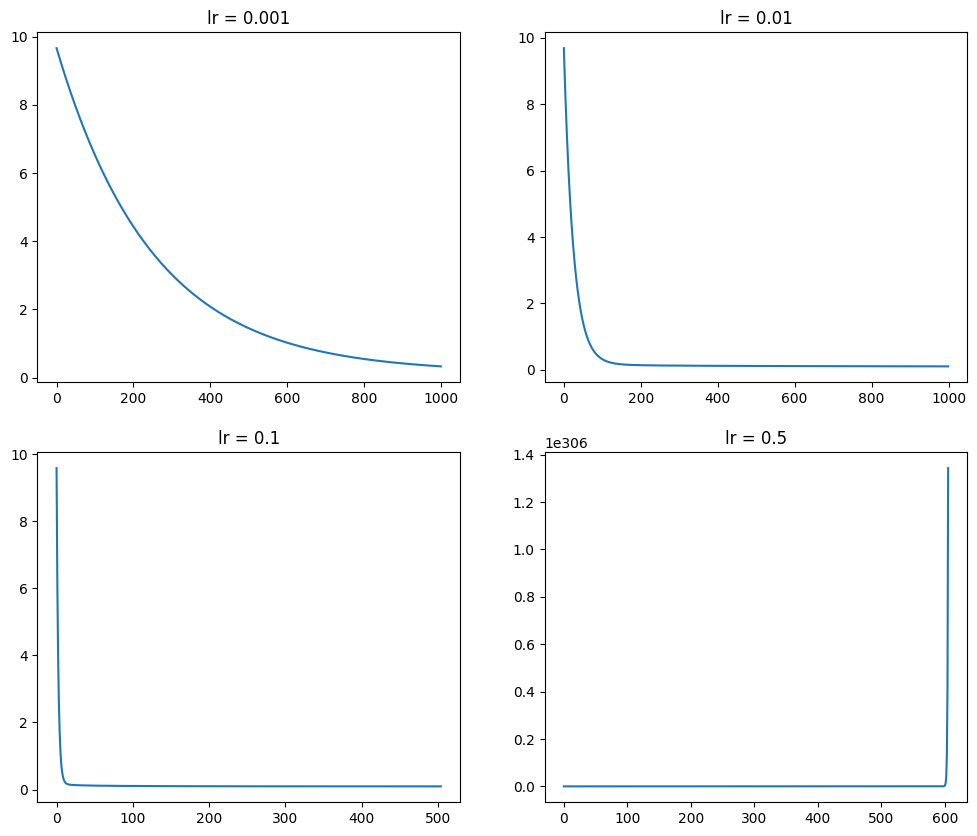

In [22]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.ravel()
for i, lr in enumerate(learning_rates):
    _, _, cost_history = fit_linear_regreesion_gd(X_train_scaled, 
                                                  y_train,
                                                  learning_rate=lr)
    axes[i].plot(cost_history)
    axes[i].set_title(f"lr = {lr}")